# Feature Extration

In [1]:
import librosa
import numpy as np
import torch

def extract_features_cnn(file_path, sr=44100, n_mfcc=20):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=sr)

    # Extract features
    rms = librosa.feature.rms(y=y).flatten()
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr).flatten()
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr).flatten()
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).flatten()
    zcr = librosa.feature.zero_crossing_rate(y).flatten()
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Stack features into a 2D "image"
    features = np.vstack([rms, spec_cent, spec_bw, rolloff, zcr, mfcc])
    return features  # Shape: (25, num_frames)

# Data Preparation

In [2]:
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import pickle

# Define the custom Dataset class
class InstrumentDataset(Dataset):
    def __init__(self, dataset_path, instruments, label_encoder, transform=None):
        self.dataset_path = dataset_path
        self.instruments = instruments
        self.label_encoder = label_encoder
        self.transform = transform

        # Collect file paths and labels
        self.file_paths = []
        self.labels = []

        for instrument in instruments:
            folder_path = os.path.join(dataset_path, instrument)
            for filename in os.listdir(folder_path):
                self.file_paths.append(os.path.join(folder_path, filename))
                self.labels.append(instrument)

        # Encode labels
        self.labels = label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Extract features
        features = extract_features_cnn(file_path)
        features = torch.tensor(features, dtype=torch.float32)

        # Apply transformations if provided
        if self.transform:
            features = self.transform(features)

        # Add a channel dimension for CNN
        features = features.unsqueeze(0)  # Shape: (1, 25, num_frames)

        return features, label


# Dataset path and instruments
dataset_path = "./../IRMAS/IRMAS-TrainingData"
instruments = 'flu pia tru org gac voi cel cla gel sax vio'.split()

# Label encoder
label_encoder = LabelEncoder()

# Create dataset and dataloader
total_dataset = InstrumentDataset(dataset_path, instruments, label_encoder)

# Split dataset into training and test sets
dataset_size = len(total_dataset)
indices = list(range(dataset_size))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Subset datasets
train_subset = torch.utils.data.Subset(total_dataset, train_indices)
test_subset = torch.utils.data.Subset(total_dataset, test_indices)


# Save the label encoder for later
with open("label_encoder_cnn.pkl", "wb") as file:
    pickle.dump(label_encoder, file)

# CNN Model


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.dropout = nn.Dropout(0.5)
        
        # Calculate flattened size dynamically
        dummy_input = torch.zeros(1, 1, 25, 258)  # (Batch size, Channels, Height, Width)
        with torch.no_grad():
            dummy_output = self.pool(self.pool(F.relu(self.conv2(F.relu(self.conv1(dummy_input))))))
        flattened_size = dummy_output.numel()  # Use .numel() to get the total number of elements
        
        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## CNN Training


In [4]:
import torch.optim as optim
from tqdm import tqdm

# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(instruments)  # Number of instrument classes
model = AudioCNN(num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
epochs = 5
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

train_accuracies = []
epoch_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    epoch_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


100%|██████████| 84/84 [02:28<00:00,  1.77s/it]


Epoch 1/5, Loss: 193.5933, Accuracy: 0.1014


100%|██████████| 84/84 [02:38<00:00,  1.88s/it]


Epoch 2/5, Loss: 2.3805, Accuracy: 0.1027


100%|██████████| 84/84 [02:38<00:00,  1.89s/it]


Epoch 3/5, Loss: 2.3795, Accuracy: 0.1081


100%|██████████| 84/84 [02:55<00:00,  2.09s/it]


Epoch 4/5, Loss: 2.3790, Accuracy: 0.1128


100%|██████████| 84/84 [02:28<00:00,  1.77s/it]

Epoch 5/5, Loss: 2.3787, Accuracy: 0.1055


## Plot Accuracy per Epoch


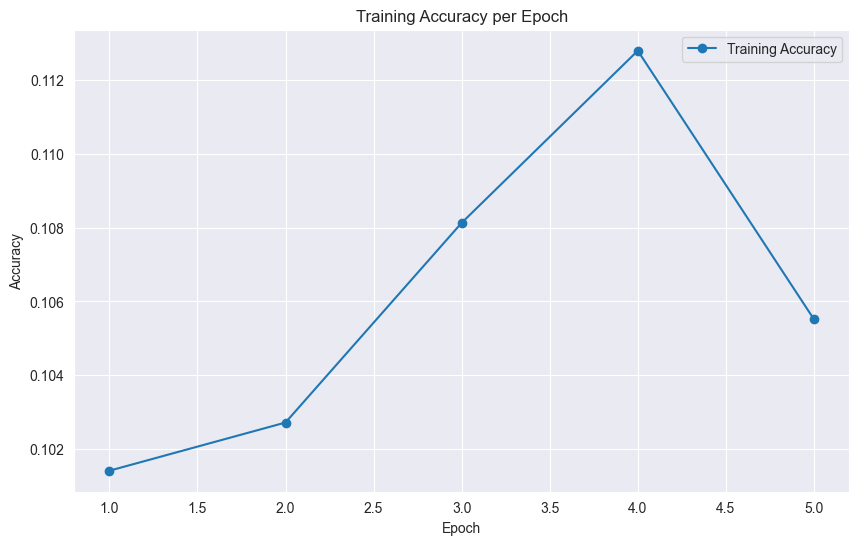

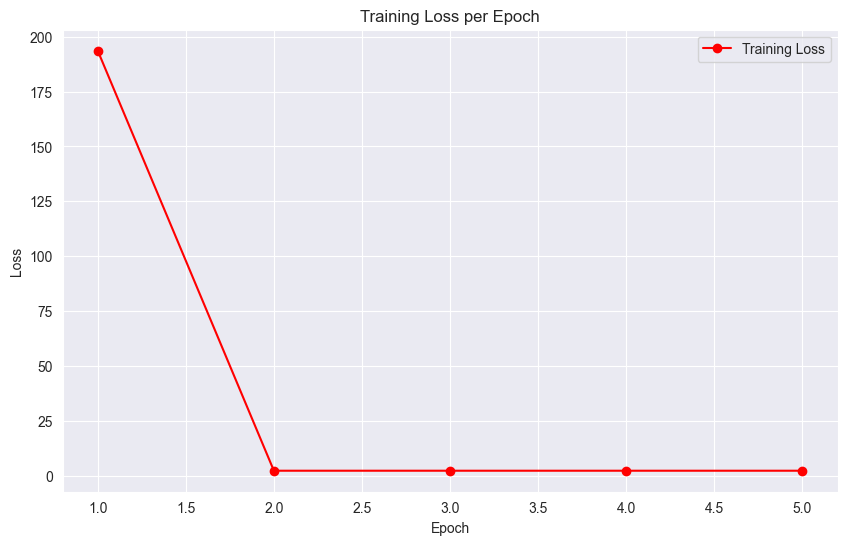

In [5]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, marker='o', label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.grid(True)
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), epoch_losses, marker='o', label='Training Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.legend()
plt.show()

## Save the Model

In [6]:
# Save the trained model
torch.save(model.state_dict(), "cnn_instrument_recognizer.pth")

## Accuracy Analysis

/Users/huangbingqi/Documents/2024_Autumn_Semester/Instrument_Recognition_SignalAndSystem/musical-instrument-classification/codes/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.1208
Precision: 0.0110
Recall: 0.0909


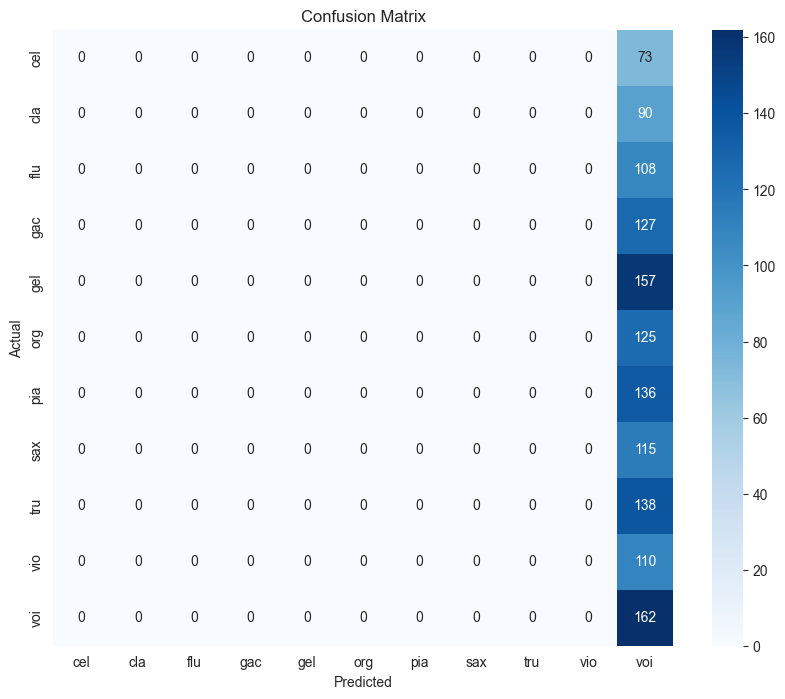

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare test data
test_loader = DataLoader(test_subset, batch_size=128, shuffle=False)

# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()